# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-kmeans'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [13]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [16]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 10)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances <= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)

        time_start = time.time()
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
        time_end = time.time()
        print(f"Model loaded in {time_end - time_start} s")
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8278, F1 Micro: 0.0483, F1 Macro: 0.017
Epoch 2/10, Train Loss: 0.4112, Accuracy: 0.8287, F1 Micro: 0.0251, F1 Macro: 0.0109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3817, Accuracy: 0.8313, F1 Micro: 0.0562, F1 Macro: 0.023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8534, F1 Micro: 0.3322, F1 Macro: 0.1087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3425, Accuracy: 0.8667, F1 Micro: 0.4499, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3131, Accuracy: 0.8731, F1 Micro: 0.6036, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2691, Accuracy: 0.8766, F1 Micro: 0.6219, F1 Macro: 0.3077
Epoch 8/10, Train Loss: 0.2634, Accuracy: 0.8822, F1 Micro: 0.5944, F1 Macro: 0.2945
Epoch 9/10, Train Loss: 0.2253, Accuracy: 0.8804, F1 Micro: 0.5629, F1 Macro: 0.2872
Epoch 10/10, Train Loss: 0.1952, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4806, Accuracy: 0.848, F1 Micro: 0.2667, F1 Macro: 0.0917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3728, Accuracy: 0.8719, F1 Micro: 0.5426, F1 Macro: 0.2393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3181, Accuracy: 0.8832, F1 Micro: 0.5823, F1 Macro: 0.2871
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2772, Accuracy: 0.8894, F1 Micro: 0.6074, F1 Macro: 0.3224
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2315, Accuracy: 0.8956, F1 Micro: 0.6808, F1 Macro: 0.4381
Epoch 6/10, Train Loss: 0.2088, Accuracy: 0.8982, F1 Micro: 0.6493, F1 Macro: 0.4597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1834, Accuracy: 0.9022, F1 Micro: 0.7023, F1 Macro: 0.5178
Epoch 8/10, Train Loss: 0.1507, Accuracy: 0.9021, F1 Micro: 0.6942, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1384, Accuracy: 0.905, F1 Micro: 0.712, F1 Macro: 0.5545
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4398, Accuracy: 0.8567, F1 Micro: 0.4064, F1 Macro: 0.1285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3224, Accuracy: 0.884, F1 Micro: 0.6518, F1 Macro: 0.3475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2613, Accuracy: 0.8974, F1 Micro: 0.6738, F1 Macro: 0.4678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2308, Accuracy: 0.9036, F1 Micro: 0.683, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9056, F1 Micro: 0.6963, F1 Macro: 0.5179
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9067, F1 Micro: 0.728, F1 Macro: 0.567
Epoch 7/10, Train Loss: 0.1283, Accuracy: 0.9085, F1 Micro: 0.7064, F1 Macro: 0.5483
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9114, F1 Micro: 0.7265, F1 Macro: 0.5724
Epoch 9/10, Train Loss: 0.0907, Accuracy: 0.9108, F1 Micro: 0.7169, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4153, Accuracy: 0.8762, F1 Micro: 0.5533, F1 Macro: 0.2504
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.8954, F1 Micro: 0.6832, F1 Macro: 0.4719
Epoch 3/10, Train Loss: 0.235, Accuracy: 0.902, F1 Micro: 0.6829, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9072, F1 Micro: 0.731, F1 Macro: 0.5345
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1634, Accuracy: 0.9124, F1 Micro: 0.739, F1 Macro: 0.5916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.913, F1 Micro: 0.7399, F1 Macro: 0.5925
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9124, F1 Micro: 0.7335, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.915, F1 Micro: 0.7405, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9112, F1 Micro: 0.7436, F1 Macro: 0.6217
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4012, Accuracy: 0.8797, F1 Micro: 0.5886, F1 Macro: 0.283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.8999, F1 Micro: 0.6676, F1 Macro: 0.3992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9077, F1 Micro: 0.7229, F1 Macro: 0.5163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9122, F1 Micro: 0.7346, F1 Macro: 0.5714
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9143, F1 Micro: 0.7288, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9157, F1 Micro: 0.7424, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9143, F1 Micro: 0.7491, F1 Macro: 0.6162
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9141, F1 Micro: 0.7461, F1 Macro: 0.6193
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9146, F1 Micro: 0.7483, F1 Macro: 0.6319
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8836, F1 Micro: 0.6294, F1 Macro: 0.3165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9021, F1 Micro: 0.6666, F1 Macro: 0.4148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9092, F1 Micro: 0.7295, F1 Macro: 0.5336
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9164, F1 Micro: 0.7332, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9166, F1 Micro: 0.7417, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.916, F1 Micro: 0.7553, F1 Macro: 0.6195
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9157, F1 Micro: 0.7507, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9172, F1 Micro: 0.7569, F1 Macro: 0.6294
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9162, F1 Micro: 0.7504, F1 Macro: 0.6289
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8903, F1 Micro: 0.6417, F1 Macro: 0.3444
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9069, F1 Micro: 0.704, F1 Macro: 0.5175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.9156, F1 Micro: 0.731, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9156, F1 Micro: 0.7518, F1 Macro: 0.5895
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9169, F1 Micro: 0.7498, F1 Macro: 0.6016
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9143, F1 Micro: 0.7487, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9195, F1 Micro: 0.7612, F1 Macro: 0.6571
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9157, F1 Micro: 0.7555, F1 Macro: 0.6356
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9177, F1 Micro: 0.7582, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.052, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.891, F1 Micro: 0.6413, F1 Macro: 0.3401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.9094, F1 Micro: 0.715, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.916, F1 Micro: 0.7477, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9175, F1 Micro: 0.7495, F1 Macro: 0.599
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9182, F1 Micro: 0.7487, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9193, F1 Micro: 0.7666, F1 Macro: 0.6464
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.9191, F1 Micro: 0.7582, F1 Macro: 0.6638
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9207, F1 Micro: 0.7589, F1 Macro: 0.667
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9195, F1 Micro: 0.7624, F1 Macro: 0.6748
Epoch 10/10, Train Loss: 0.0507, Accuracy: 0.923, F1 Micro: 0.7624, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.8939, F1 Micro: 0.6673, F1 Macro: 0.3804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9091, F1 Micro: 0.7174, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9155, F1 Micro: 0.7225, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9153, F1 Micro: 0.7573, F1 Macro: 0.6071
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.92, F1 Micro: 0.7561, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9184, F1 Micro: 0.7587, F1 Macro: 0.6539
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9181, F1 Micro: 0.7544, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.92, F1 Micro: 0.7653, F1 Macro: 0.6785
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9205, F1 Micro: 0.7563, F1 Macro: 0.6627
Epoch 10/10, Train Loss: 0.0536, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.8945, F1 Micro: 0.6574, F1 Macro: 0.3827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.9092, F1 Micro: 0.7192, F1 Macro: 0.5542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9192, F1 Micro: 0.7452, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9101, F1 Micro: 0.7548, F1 Macro: 0.6231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9189, F1 Micro: 0.7609, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9195, F1 Micro: 0.7657, F1 Macro: 0.6425
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.921, F1 Micro: 0.7583, F1 Macro: 0.6567
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9196, F1 Micro: 0.7596, F1 Macro: 0.6537
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9204, F1 Micro: 0.7577, F1 Macro: 0.6607
Epoch 10/10, Train Loss: 0.0523, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3613, Accuracy: 0.8967, F1 Micro: 0.6809, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.238, Accuracy: 0.9142, F1 Micro: 0.7427, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9183, F1 Micro: 0.7452, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9188, F1 Micro: 0.7647, F1 Macro: 0.6362
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9212, F1 Micro: 0.7588, F1 Macro: 0.632
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9202, F1 Micro: 0.7625, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9223, F1 Micro: 0.7715, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9212, F1 Micro: 0.7753, F1 Macro: 0.6841
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.924, F1 Micro: 0.7661, F1 Macro: 0.701
Epoch 10/10, Train Loss: 0.0507, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3564, Accuracy: 0.898, F1 Micro: 0.6704, F1 Macro: 0.4068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2342, Accuracy: 0.9134, F1 Micro: 0.7363, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9198, F1 Micro: 0.7656, F1 Macro: 0.6236
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9218, F1 Micro: 0.7611, F1 Macro: 0.626
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9205, F1 Micro: 0.7458, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9239, F1 Micro: 0.7669, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.925, F1 Micro: 0.7741, F1 Macro: 0.6851
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9203, F1 Micro: 0.7656, F1 Macro: 0.6922
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9218, F1 Micro: 0.7709, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0444, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3484, Accuracy: 0.8977, F1 Micro: 0.6493, F1 Macro: 0.3809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9163, F1 Micro: 0.7399, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9208, F1 Micro: 0.7485, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.923, F1 Micro: 0.7725, F1 Macro: 0.6463
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9171, F1 Micro: 0.7666, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9249, F1 Micro: 0.7785, F1 Macro: 0.6807
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9241, F1 Micro: 0.7721, F1 Macro: 0.6793
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9244, F1 Micro: 0.7782, F1 Macro: 0.7007
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9246, F1 Micro: 0.7692, F1 Macro: 0.6998
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9237, F1 Micro: 0.7781, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3481, Accuracy: 0.9005, F1 Micro: 0.6939, F1 Macro: 0.4512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2299, Accuracy: 0.9141, F1 Micro: 0.7234, F1 Macro: 0.5519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9197, F1 Micro: 0.7664, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9227, F1 Micro: 0.7708, F1 Macro: 0.6632
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9151, F1 Micro: 0.7677, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9234, F1 Micro: 0.7762, F1 Macro: 0.6773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9234, F1 Micro: 0.7764, F1 Macro: 0.6951
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9189, F1 Micro: 0.7742, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9233, F1 Micro: 0.772, F1 Macro: 0.7019
Epoch 10/10, Train Loss: 0.0436, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3413, Accuracy: 0.8962, F1 Micro: 0.6227, F1 Macro: 0.3747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2268, Accuracy: 0.9174, F1 Micro: 0.739, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9211, F1 Micro: 0.7706, F1 Macro: 0.6234
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9235, F1 Micro: 0.7671, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9235, F1 Micro: 0.7823, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9266, F1 Micro: 0.7833, F1 Macro: 0.689
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9252, F1 Micro: 0.7797, F1 Macro: 0.6939
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9245, F1 Micro: 0.7784, F1 Macro: 0.7041
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9251, F1 Micro: 0.7835, F1 Macro: 0.7114
Epoch 10/10, Train Loss: 0.0436, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3419, Accuracy: 0.9011, F1 Micro: 0.6737, F1 Macro: 0.4492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.9168, F1 Micro: 0.7481, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.923, F1 Micro: 0.7619, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9248, F1 Micro: 0.7794, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9265, F1 Micro: 0.784, F1 Macro: 0.6845
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9248, F1 Micro: 0.77, F1 Macro: 0.6865
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9245, F1 Micro: 0.7783, F1 Macro: 0.7113
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9219, F1 Micro: 0.7756, F1 Macro: 0.7056
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9253, F1 Micro: 0.7785, F1 Macro: 0.7056
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9224, F1 Micro: 0.7798, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3426, Accuracy: 0.9023, F1 Micro: 0.6966, F1 Macro: 0.5074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2239, Accuracy: 0.9172, F1 Micro: 0.751, F1 Macro: 0.5705
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9215, F1 Micro: 0.7485, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9242, F1 Micro: 0.7724, F1 Macro: 0.6582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9251, F1 Micro: 0.7768, F1 Macro: 0.6751
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9211, F1 Micro: 0.7749, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9258, F1 Micro: 0.7803, F1 Macro: 0.7053
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9261, F1 Micro: 0.7803, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9271, F1 Micro: 0.781, F1 Macro: 0.7089
Epoch 10/10, Train Loss: 0.0425, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3395, Accuracy: 0.9031, F1 Micro: 0.6732, F1 Macro: 0.4662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2229, Accuracy: 0.9189, F1 Micro: 0.7508, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9203, F1 Micro: 0.7667, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9273, F1 Micro: 0.7763, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.9257, F1 Micro: 0.7785, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9268, F1 Micro: 0.788, F1 Macro: 0.6908
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9253, F1 Micro: 0.7843, F1 Macro: 0.7132
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9285, F1 Micro: 0.7815, F1 Macro: 0.7132
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9267, F1 Micro: 0.7844, F1 Macro: 0.7184
Epoch 10/10, Train Loss: 0.0443, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3367, Accuracy: 0.9007, F1 Micro: 0.6697, F1 Macro: 0.4293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2235, Accuracy: 0.9192, F1 Micro: 0.7543, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9243, F1 Micro: 0.7655, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9262, F1 Micro: 0.7741, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9262, F1 Micro: 0.7824, F1 Macro: 0.6703
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9241, F1 Micro: 0.7761, F1 Macro: 0.6777
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9261, F1 Micro: 0.7705, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9271, F1 Micro: 0.7881, F1 Macro: 0.7176
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.925, F1 Micro: 0.78, F1 Macro: 0.7074
Epoch 10/10, Train Loss: 0.0451, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3391, Accuracy: 0.9021, F1 Micro: 0.7128, F1 Macro: 0.5157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.9196, F1 Micro: 0.7495, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9231, F1 Micro: 0.7656, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9177, F1 Micro: 0.7667, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9254, F1 Micro: 0.7776, F1 Macro: 0.6804
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9244, F1 Micro: 0.777, F1 Macro: 0.7004
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9261, F1 Micro: 0.7855, F1 Macro: 0.7125
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9238, F1 Micro: 0.7784, F1 Macro: 0.7137
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9265, F1 Micro: 0.7776, F1 Macro: 0.7069
Epoch 10/10, Train Loss: 0.0389, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3397, Accuracy: 0.9004, F1 Micro: 0.673, F1 Macro: 0.4109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9197, F1 Micro: 0.7625, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9233, F1 Micro: 0.7763, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.927, F1 Micro: 0.7816, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.9262, F1 Micro: 0.7844, F1 Macro: 0.6803
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9251, F1 Micro: 0.7811, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9253, F1 Micro: 0.787, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9253, F1 Micro: 0.783, F1 Macro: 0.72
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9213, F1 Micro: 0.7806, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3361, Accuracy: 0.9044, F1 Micro: 0.691, F1 Macro: 0.4721
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9185, F1 Micro: 0.7595, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9237, F1 Micro: 0.7734, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9246, F1 Micro: 0.7805, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9259, F1 Micro: 0.7869, F1 Macro: 0.7043
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9287, F1 Micro: 0.781, F1 Macro: 0.7002
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9282, F1 Micro: 0.7793, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9274, F1 Micro: 0.7889, F1 Macro: 0.7217
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.925, F1 Micro: 0.7782, F1 Macro: 0.7187
Epoch 10/10, Train Loss: 0.0405, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3355, Accuracy: 0.9018, F1 Micro: 0.6654, F1 Macro: 0.4252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.9184, F1 Micro: 0.7515, F1 Macro: 0.6022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9275, F1 Micro: 0.7753, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9246, F1 Micro: 0.7814, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1074, Accuracy: 0.9263, F1 Micro: 0.7815, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9286, F1 Micro: 0.791, F1 Macro: 0.7209
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9283, F1 Micro: 0.7845, F1 Macro: 0.7117
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9276, F1 Micro: 0.7895, F1 Macro: 0.7267
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9276, F1 Micro: 0.7823, F1 Macro: 0.7159
Epoch 10/10, Train Loss: 0.0439, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.907, F1 Micro: 0.7076, F1 Macro: 0.4979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.9204, F1 Micro: 0.7601, F1 Macro: 0.5935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9257, F1 Micro: 0.778, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9289, F1 Micro: 0.7853, F1 Macro: 0.6873
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9271, F1 Micro: 0.7847, F1 Macro: 0.7053
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.926, F1 Micro: 0.7843, F1 Macro: 0.6943
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9254, F1 Micro: 0.7825, F1 Macro: 0.7038
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9271, F1 Micro: 0.7812, F1 Macro: 0.7189
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.925, F1 Micro: 0.7796, F1 Macro: 0.7199
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9268, F1 Micro: 0.784, F1 Macro: 0.719

 Iteration 9818: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3338, Accuracy: 0.9061, F1 Micro: 0.6973, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.9194, F1 Micro: 0.7473, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9249, F1 Micro: 0.7782, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9253, F1 Micro: 0.7846, F1 Macro: 0.6691
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9273, F1 Micro: 0.7731, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9248, F1 Micro: 0.7885, F1 Macro: 0.7215
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9253, F1 Micro: 0.7845, F1 Macro: 0.7107
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9265, F1 Micro: 0.7878, F1 Macro: 0.72
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9273, F1 Micro: 0.782, F1 Macro: 0.7209
Epoch 10/10, Train Loss: 0.0428, Accuracy: 0.9278, F1 Micro: 0.7843, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3315, Accuracy: 0.9058, F1 Micro: 0.7044, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2208, Accuracy: 0.9208, F1 Micro: 0.7656, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9254, F1 Micro: 0.77, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9226, F1 Micro: 0.7834, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9267, F1 Micro: 0.7843, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9299, F1 Micro: 0.7873, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9274, F1 Micro: 0.7894, F1 Macro: 0.7241
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9272, F1 Micro: 0.7868, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9271, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3301, Accuracy: 0.9065, F1 Micro: 0.6961, F1 Macro: 0.4326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9222, F1 Micro: 0.7634, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9222, F1 Micro: 0.7787, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9274, F1 Micro: 0.7868, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.9285, F1 Micro: 0.7888, F1 Macro: 0.6979
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9282, F1 Micro: 0.7874, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9287, F1 Micro: 0.7903, F1 Macro: 0.7209
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9246, F1 Micro: 0.7805, F1 Macro: 0.719
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9256, F1 Micro: 0.784, F1 Macro: 0.7179
Epoch 10/10, Train Loss: 0.0422, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3269, Accuracy: 0.9058, F1 Micro: 0.6901, F1 Macro: 0.499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2182, Accuracy: 0.9195, F1 Micro: 0.7596, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9227, F1 Micro: 0.7731, F1 Macro: 0.615
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9264, F1 Micro: 0.7676, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.9272, F1 Micro: 0.7874, F1 Macro: 0.6876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9286, F1 Micro: 0.793, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9306, F1 Micro: 0.7946, F1 Macro: 0.7262
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9284, F1 Micro: 0.7799, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9299, F1 Micro: 0.7968, F1 Macro: 0.7275
Epoch 10/

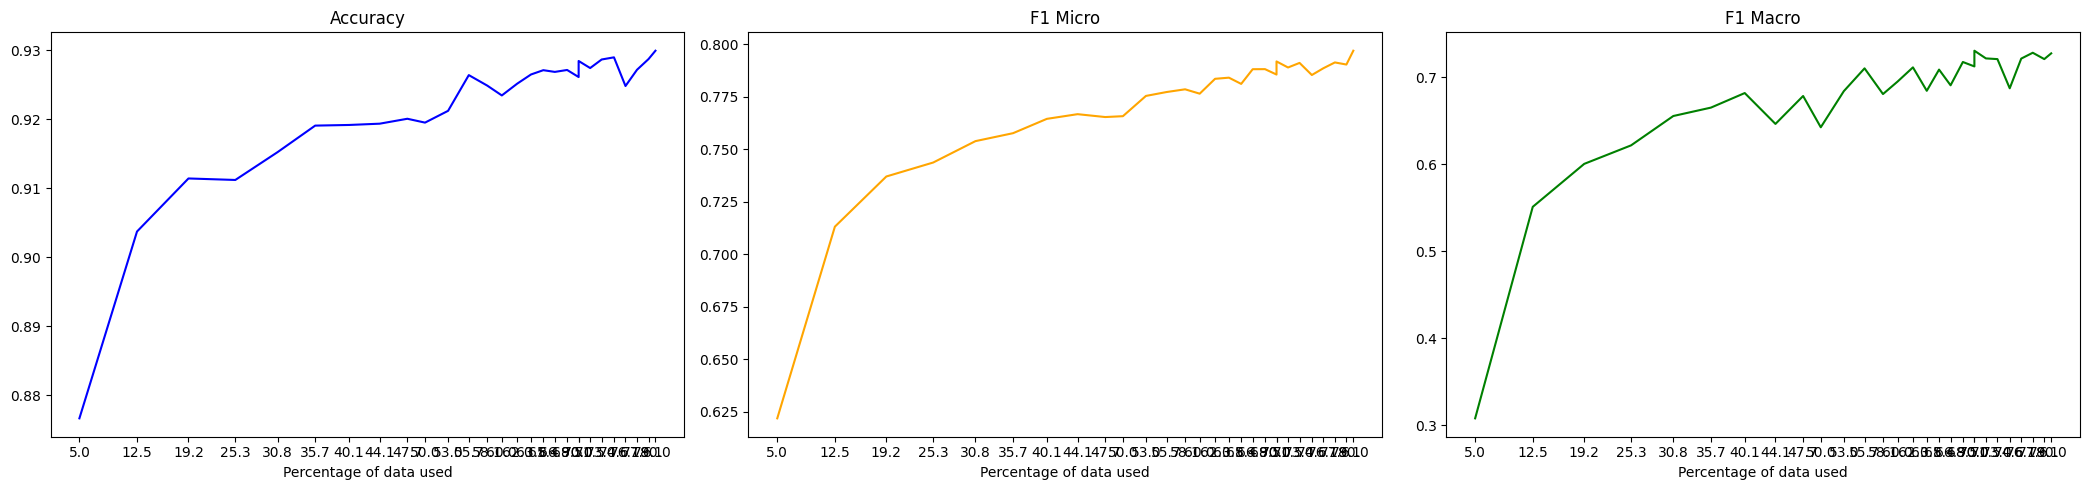

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.8301, F1 Micro: 0.2873, F1 Macro: 0.0657
Epoch 2/10, Train Loss: 0.3962, Accuracy: 0.836, F1 Micro: 0.144, F1 Macro: 0.0516
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8477, F1 Micro: 0.2738, F1 Macro: 0.0968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.342, Accuracy: 0.8656, F1 Micro: 0.4801, F1 Macro: 0.2063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3117, Accuracy: 0.8768, F1 Micro: 0.5736, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2746, Accuracy: 0.88, F1 Micro: 0.5854, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2515, Accuracy: 0.8841, F1 Micro: 0.5877, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2305, Accuracy: 0.8869, F1 Micro: 0.6337, F1 Macro: 0.3399
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2015, Accuracy: 0.8891, F1 Micro: 0.6409, F1 Macro: 0.3499
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4697, Accuracy: 0.8434, F1 Micro: 0.2299, F1 Macro: 0.0788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3598, Accuracy: 0.8785, F1 Micro: 0.5524, F1 Macro: 0.2541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2906, Accuracy: 0.8861, F1 Micro: 0.6352, F1 Macro: 0.3216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2578, Accuracy: 0.895, F1 Micro: 0.6374, F1 Macro: 0.3903
Epoch 5/10, Train Loss: 0.2146, Accuracy: 0.8968, F1 Micro: 0.6328, F1 Macro: 0.4303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1964, Accuracy: 0.9038, F1 Micro: 0.6905, F1 Macro: 0.497
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1773, Accuracy: 0.9059, F1 Micro: 0.7114, F1 Macro: 0.5256
Epoch 8/10, Train Loss: 0.138, Accuracy: 0.9059, F1 Micro: 0.7105, F1 Macro: 0.512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1235, Accuracy: 0.9058, F1 Micro: 0.7158, F1 Macro: 0.5442
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4338, Accuracy: 0.8598, F1 Micro: 0.4123, F1 Macro: 0.1477
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.321, Accuracy: 0.8891, F1 Micro: 0.6181, F1 Macro: 0.3208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.892, F1 Micro: 0.6849, F1 Macro: 0.4181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2256, Accuracy: 0.9018, F1 Micro: 0.7169, F1 Macro: 0.5212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.183, Accuracy: 0.9084, F1 Micro: 0.7188, F1 Macro: 0.54
Epoch 6/10, Train Loss: 0.1543, Accuracy: 0.9097, F1 Micro: 0.7152, F1 Macro: 0.5315
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1272, Accuracy: 0.91, F1 Micro: 0.7366, F1 Macro: 0.5744
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.9125, F1 Micro: 0.7354, F1 Macro: 0.5829
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9119, F1 Micro: 0.7334, F1 Macro: 0.5818
Epoch 10/10, Train Loss: 0.0856, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.8787, F1 Micro: 0.5446, F1 Macro: 0.2524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2849, Accuracy: 0.895, F1 Micro: 0.6673, F1 Macro: 0.3976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2331, Accuracy: 0.9037, F1 Micro: 0.7, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1947, Accuracy: 0.9075, F1 Micro: 0.7188, F1 Macro: 0.5321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.907, F1 Micro: 0.7279, F1 Macro: 0.5523
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9097, F1 Micro: 0.715, F1 Macro: 0.5589
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9095, F1 Micro: 0.7196, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9108, F1 Micro: 0.7318, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.913, F1 Micro: 0.7404, F1 Macro: 0.6183
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8804, F1 Micro: 0.557, F1 Macro: 0.2725
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.903, F1 Micro: 0.675, F1 Macro: 0.448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9089, F1 Micro: 0.7272, F1 Macro: 0.538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9114, F1 Micro: 0.732, F1 Macro: 0.5457
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.912, F1 Micro: 0.7228, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9146, F1 Micro: 0.7418, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9132, F1 Micro: 0.7464, F1 Macro: 0.6058
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9154, F1 Micro: 0.7399, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.915, F1 Micro: 0.7489, F1 Macro: 0.6457
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3815, Accuracy: 0.8847, F1 Micro: 0.655, F1 Macro: 0.3404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.9024, F1 Micro: 0.6883, F1 Macro: 0.4406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.912, F1 Micro: 0.7242, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9147, F1 Micro: 0.7472, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9151, F1 Micro: 0.7549, F1 Macro: 0.5969
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9176, F1 Micro: 0.7528, F1 Macro: 0.6199
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9184, F1 Micro: 0.7468, F1 Macro: 0.61
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.919, F1 Micro: 0.748, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9191, F1 Micro: 0.7626, F1 Macro: 0.6645
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8919, F1 Micro: 0.6483, F1 Macro: 0.3549
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.9091, F1 Micro: 0.7202, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.914, F1 Micro: 0.7321, F1 Macro: 0.5463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9191, F1 Micro: 0.7421, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9178, F1 Micro: 0.7441, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9203, F1 Micro: 0.7524, F1 Macro: 0.6134
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9221, F1 Micro: 0.7635, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9204, F1 Micro: 0.7648, F1 Macro: 0.6527
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9192, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3625, Accuracy: 0.8952, F1 Micro: 0.6669, F1 Macro: 0.3742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.911, F1 Micro: 0.7178, F1 Macro: 0.5318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.9148, F1 Micro: 0.7497, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9208, F1 Micro: 0.7511, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9194, F1 Micro: 0.7575, F1 Macro: 0.6313
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9193, F1 Micro: 0.7543, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.919, F1 Micro: 0.7628, F1 Macro: 0.6441
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9199, F1 Micro: 0.7621, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9204, F1 Micro: 0.766, F1 Macro: 0.6754
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.8947, F1 Micro: 0.6746, F1 Macro: 0.3881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.9113, F1 Micro: 0.7359, F1 Macro: 0.5498
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.916, F1 Micro: 0.7233, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9208, F1 Micro: 0.7506, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9223, F1 Micro: 0.768, F1 Macro: 0.6411
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9202, F1 Micro: 0.7724, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9214, F1 Micro: 0.772, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9235, F1 Micro: 0.7754, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9249, F1 Micro: 0.7758, F1 Macro: 0.6885
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3556, Accuracy: 0.8966, F1 Micro: 0.6802, F1 Macro: 0.3884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.9121, F1 Micro: 0.7321, F1 Macro: 0.5176
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9173, F1 Micro: 0.7285, F1 Macro: 0.5407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9222, F1 Micro: 0.7629, F1 Macro: 0.6008
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9211, F1 Micro: 0.7581, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.925, F1 Micro: 0.7769, F1 Macro: 0.6574
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9216, F1 Micro: 0.7759, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9251, F1 Micro: 0.7772, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9238, F1 Micro: 0.7775, F1 Macro: 0.6919
Epoch 10/10, Train Loss: 0.0463, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.8963, F1 Micro: 0.6958, F1 Macro: 0.4386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2295, Accuracy: 0.9018, F1 Micro: 0.7358, F1 Macro: 0.5596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9187, F1 Micro: 0.7558, F1 Macro: 0.6075
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9216, F1 Micro: 0.7544, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9189, F1 Micro: 0.7703, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9228, F1 Micro: 0.7733, F1 Macro: 0.6637
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9199, F1 Micro: 0.7715, F1 Macro: 0.6743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9225, F1 Micro: 0.7748, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9244, F1 Micro: 0.7746, F1 Macro: 0.7051
Epoch 10/10, Train Loss: 0.0485, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8973, F1 Micro: 0.695, F1 Macro: 0.4496
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2305, Accuracy: 0.9122, F1 Micro: 0.7251, F1 Macro: 0.5266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9208, F1 Micro: 0.7597, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9219, F1 Micro: 0.761, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.924, F1 Micro: 0.7747, F1 Macro: 0.6488
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9252, F1 Micro: 0.7723, F1 Macro: 0.6557
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9244, F1 Micro: 0.7701, F1 Macro: 0.67
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9227, F1 Micro: 0.7672, F1 Macro: 0.6767
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.922, F1 Micro: 0.7721, F1 Macro: 0.7035
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9179, F1 Micro: 0.7658, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3479, Accuracy: 0.8999, F1 Micro: 0.663, F1 Macro: 0.4121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2265, Accuracy: 0.9148, F1 Micro: 0.7268, F1 Macro: 0.5421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9211, F1 Micro: 0.7576, F1 Macro: 0.5905
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9238, F1 Micro: 0.753, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9214, F1 Micro: 0.7722, F1 Macro: 0.6704
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9247, F1 Micro: 0.7662, F1 Macro: 0.6567
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9193, F1 Micro: 0.7721, F1 Macro: 0.6919
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9229, F1 Micro: 0.781, F1 Macro: 0.6989
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9239, F1 Micro: 0.7786, F1 Macro: 0.7077
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.9188, F1 Micro: 0.7753, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3419, Accuracy: 0.8998, F1 Micro: 0.7006, F1 Macro: 0.4572
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9145, F1 Micro: 0.7401, F1 Macro: 0.5393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9211, F1 Micro: 0.7661, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9247, F1 Micro: 0.7751, F1 Macro: 0.6377
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9266, F1 Micro: 0.7744, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9254, F1 Micro: 0.7796, F1 Macro: 0.6724
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9244, F1 Micro: 0.7779, F1 Macro: 0.6779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9244, F1 Micro: 0.7799, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9269, F1 Micro: 0.7813, F1 Macro: 0.7144
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3381, Accuracy: 0.9029, F1 Micro: 0.6735, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.223, Accuracy: 0.9166, F1 Micro: 0.7515, F1 Macro: 0.5731
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.921, F1 Micro: 0.7449, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9204, F1 Micro: 0.7668, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9245, F1 Micro: 0.7714, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9258, F1 Micro: 0.7785, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9238, F1 Micro: 0.7784, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9218, F1 Micro: 0.779, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9258, F1 Micro: 0.7815, F1 Macro: 0.7143
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.9043, F1 Micro: 0.695, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9165, F1 Micro: 0.7297, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9211, F1 Micro: 0.7668, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.924, F1 Micro: 0.7796, F1 Macro: 0.6465
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9219, F1 Micro: 0.7769, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9276, F1 Micro: 0.7831, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9259, F1 Micro: 0.7854, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9271, F1 Micro: 0.7874, F1 Macro: 0.716
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.927, F1 Micro: 0.7802, F1 Macro: 0.7093
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3333, Accuracy: 0.9012, F1 Micro: 0.6628, F1 Macro: 0.4668
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.9135, F1 Micro: 0.7567, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9162, F1 Micro: 0.766, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.924, F1 Micro: 0.7764, F1 Macro: 0.6339
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9248, F1 Micro: 0.7845, F1 Macro: 0.6835
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9243, F1 Micro: 0.7732, F1 Macro: 0.6864
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.926, F1 Micro: 0.7845, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9266, F1 Micro: 0.7895, F1 Macro: 0.7185
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.923, F1 Micro: 0.7837, F1 Macro: 0.7197
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3367, Accuracy: 0.9029, F1 Micro: 0.6645, F1 Macro: 0.4425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.9168, F1 Micro: 0.7536, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9233, F1 Micro: 0.7745, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1399, Accuracy: 0.9257, F1 Micro: 0.777, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9266, F1 Micro: 0.7772, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9271, F1 Micro: 0.7808, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9228, F1 Micro: 0.7811, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9295, F1 Micro: 0.787, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9279, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3346, Accuracy: 0.9048, F1 Micro: 0.6871, F1 Macro: 0.4744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.9168, F1 Micro: 0.7518, F1 Macro: 0.5776
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.923, F1 Micro: 0.7583, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9208, F1 Micro: 0.7615, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9264, F1 Micro: 0.7752, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.923, F1 Micro: 0.7818, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9277, F1 Micro: 0.7852, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9262, F1 Micro: 0.7856, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3315, Accuracy: 0.9038, F1 Micro: 0.7014, F1 Macro: 0.4707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.222, Accuracy: 0.9163, F1 Micro: 0.7518, F1 Macro: 0.5697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9249, F1 Micro: 0.769, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9262, F1 Micro: 0.7807, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9254, F1 Micro: 0.7829, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9281, F1 Micro: 0.7902, F1 Macro: 0.6986
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9265, F1 Micro: 0.7871, F1 Macro: 0.7114
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9239, F1 Micro: 0.7868, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9295, F1 Micro: 0.7912, F1 Macro: 0.7249
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3349, Accuracy: 0.9077, F1 Micro: 0.71, F1 Macro: 0.479
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9196, F1 Micro: 0.7511, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9247, F1 Micro: 0.7752, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9235, F1 Micro: 0.7772, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9228, F1 Micro: 0.7809, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9235, F1 Micro: 0.782, F1 Macro: 0.7
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9259, F1 Micro: 0.7793, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9288, F1 Micro: 0.7888, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9294, F1 Micro: 0.790

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3325, Accuracy: 0.9062, F1 Micro: 0.7119, F1 Macro: 0.5102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.9163, F1 Micro: 0.7585, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9243, F1 Micro: 0.7702, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9247, F1 Micro: 0.7838, F1 Macro: 0.6642
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9286, F1 Micro: 0.779, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9276, F1 Micro: 0.7897, F1 Macro: 0.6866
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.925, F1 Micro: 0.7853, F1 Macro: 0.7092
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9218, F1 Micro: 0.78, F1 Macro: 0.704
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9281, F1 Micro: 0.7833, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0431, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3333, Accuracy: 0.9066, F1 Micro: 0.6866, F1 Macro: 0.4747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2175, Accuracy: 0.918, F1 Micro: 0.7645, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9269, F1 Micro: 0.784, F1 Macro: 0.6311
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9277, F1 Micro: 0.7745, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9251, F1 Micro: 0.785, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9269, F1 Micro: 0.7876, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9277, F1 Micro: 0.7884, F1 Macro: 0.6999
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9251, F1 Micro: 0.7842, F1 Macro: 0.7112
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9282, F1 Micro: 0.7876, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3298, Accuracy: 0.9066, F1 Micro: 0.7043, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.222, Accuracy: 0.9189, F1 Micro: 0.7506, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.925, F1 Micro: 0.7762, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9277, F1 Micro: 0.7785, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9273, F1 Micro: 0.7841, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9276, F1 Micro: 0.7892, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.93, F1 Micro: 0.7907, F1 Macro: 0.7169
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9263, F1 Micro: 0.784, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9307, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3284, Accuracy: 0.9052, F1 Micro: 0.6929, F1 Macro: 0.4671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2227, Accuracy: 0.9194, F1 Micro: 0.7571, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9192, F1 Micro: 0.7725, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9276, F1 Micro: 0.7868, F1 Macro: 0.6651
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9246, F1 Micro: 0.7802, F1 Macro: 0.65
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9253, F1 Micro: 0.7846, F1 Macro: 0.6955
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9269, F1 Micro: 0.7911, F1 Macro: 0.7158
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.928, F1 Micro: 0.7866, F1 Macro: 0.7187
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9248, F1 Micro: 0.7884, F1 Macro: 0.7286
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9269, F1 Micro: 0.7756, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.9061, F1 Micro: 0.6892, F1 Macro: 0.4557
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2222, Accuracy: 0.9202, F1 Micro: 0.7483, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9248, F1 Micro: 0.7686, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9271, F1 Micro: 0.7809, F1 Macro: 0.6679
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9266, F1 Micro: 0.7799, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9249, F1 Micro: 0.784, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9291, F1 Micro: 0.7924, F1 Macro: 0.7042
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9289, F1 Micro: 0.7897, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9286, F1 Micro: 0.7917, F1 Macro: 0.7312
Epoch 10/10, Train Loss: 0.043, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3226, Accuracy: 0.9054, F1 Micro: 0.6795, F1 Macro: 0.466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.9198, F1 Micro: 0.7615, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1662, Accuracy: 0.9244, F1 Micro: 0.7774, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.929, F1 Micro: 0.7869, F1 Macro: 0.6604
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9251, F1 Micro: 0.7715, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9289, F1 Micro: 0.7872, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9285, F1 Micro: 0.7913, F1 Macro: 0.7269
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9311, F1 Micro: 0.7972, F1 Macro: 0.7223
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9297, F1 Micro: 0.7921, F1 Macro: 0.7244
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3243, Accuracy: 0.9082, F1 Micro: 0.7222, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2195, Accuracy: 0.9206, F1 Micro: 0.754, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9277, F1 Micro: 0.7827, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9297, F1 Micro: 0.7922, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9289, F1 Micro: 0.7939, F1 Macro: 0.6752
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.929, F1 Micro: 0.7843, F1 Macro: 0.7045
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9266, F1 Micro: 0.79, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9301, F1 Micro: 0.7876, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9306, F1 Micro: 0.7973, F1 Macro: 0.7235
Epoch 10/10, Train Loss: 0.0415, Accuracy: 

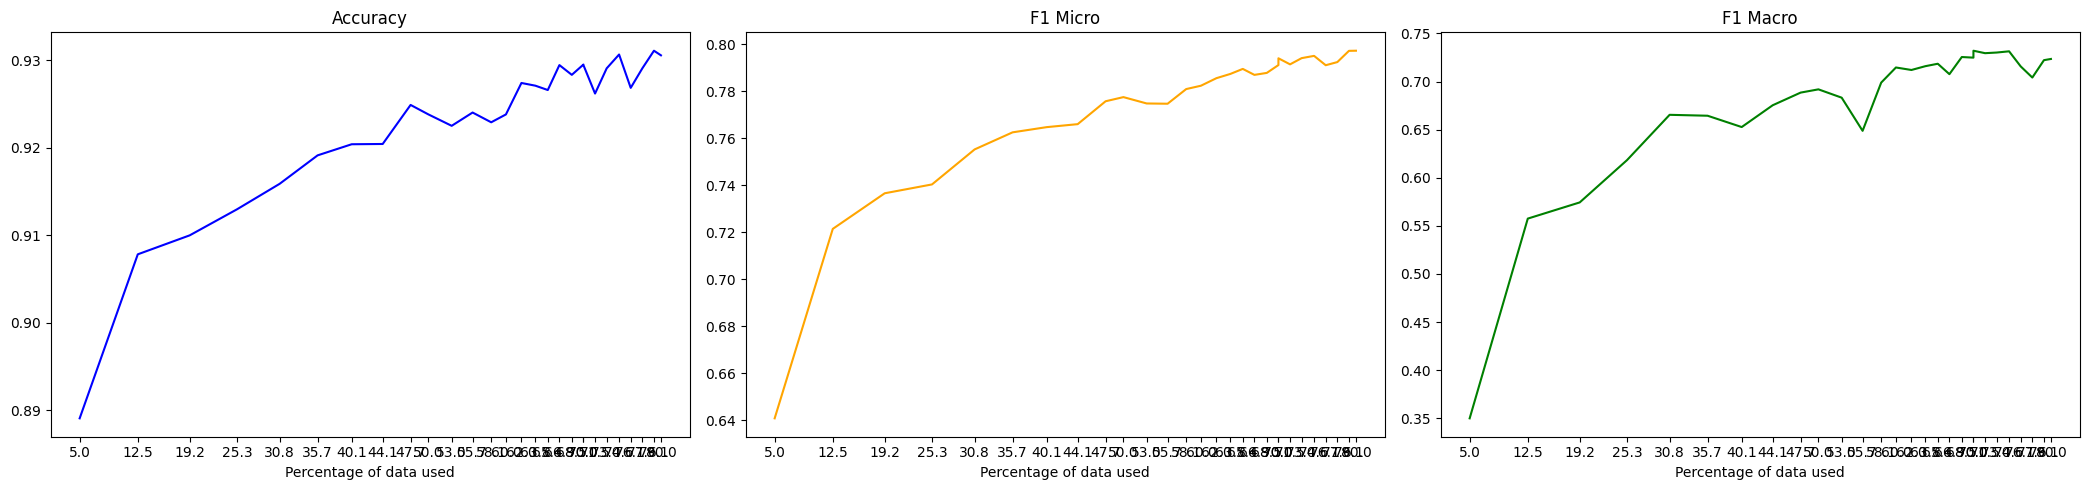

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.8293, F1 Micro: 0.063, F1 Macro: 0.0218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.8417, F1 Micro: 0.2125, F1 Macro: 0.0699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.389, Accuracy: 0.8438, F1 Micro: 0.2285, F1 Macro: 0.0804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3539, Accuracy: 0.8604, F1 Micro: 0.4052, F1 Macro: 0.1597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8723, F1 Micro: 0.5143, F1 Macro: 0.2487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2817, Accuracy: 0.8774, F1 Micro: 0.5561, F1 Macro: 0.2819
Epoch 7/10, Train Loss: 0.2562, Accuracy: 0.8755, F1 Micro: 0.5114, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2286, Accuracy: 0.884, F1 Micro: 0.5828, F1 Macro: 0.3379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.204, Accuracy: 0.8891, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4621, Accuracy: 0.8499, F1 Micro: 0.367, F1 Macro: 0.1107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3533, Accuracy: 0.87, F1 Micro: 0.4918, F1 Macro: 0.2282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2903, Accuracy: 0.8841, F1 Micro: 0.6172, F1 Macro: 0.3268
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2484, Accuracy: 0.8925, F1 Micro: 0.654, F1 Macro: 0.4168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2152, Accuracy: 0.8953, F1 Micro: 0.6554, F1 Macro: 0.4014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1878, Accuracy: 0.8978, F1 Micro: 0.6913, F1 Macro: 0.4955
Epoch 7/10, Train Loss: 0.1673, Accuracy: 0.8997, F1 Micro: 0.6781, F1 Macro: 0.4677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1381, Accuracy: 0.9002, F1 Micro: 0.7018, F1 Macro: 0.5153
Epoch 9/10, Train Loss: 0.1199, Accuracy: 0.9014, F1 Micro: 0.6983, F1 Macro: 0.517
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4264, Accuracy: 0.8617, F1 Micro: 0.4263, F1 Macro: 0.1553
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3072, Accuracy: 0.8861, F1 Micro: 0.6178, F1 Macro: 0.3347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.8962, F1 Micro: 0.6531, F1 Macro: 0.3915
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2228, Accuracy: 0.9054, F1 Micro: 0.6959, F1 Macro: 0.4857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.9025, F1 Micro: 0.7114, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.9063, F1 Micro: 0.7132, F1 Macro: 0.5485
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1249, Accuracy: 0.9107, F1 Micro: 0.7263, F1 Macro: 0.5754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9091, F1 Micro: 0.7317, F1 Macro: 0.5729
Epoch 9/10, Train Loss: 0.1008, Accuracy: 0.9097, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.875, F1 Micro: 0.5395, F1 Macro: 0.2543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.8993, F1 Micro: 0.6736, F1 Macro: 0.4381
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.9012, F1 Micro: 0.6469, F1 Macro: 0.4511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.9076, F1 Micro: 0.7258, F1 Macro: 0.5538
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.913, F1 Micro: 0.7248, F1 Macro: 0.5686
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9146, F1 Micro: 0.7249, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9095, F1 Micro: 0.7449, F1 Macro: 0.5969
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.914, F1 Micro: 0.744, F1 Macro: 0.5938
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9126, F1 Micro: 0.7394, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0681, Accuracy: 0.9144, F1 Micro: 0.745, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8793, F1 Micro: 0.5898, F1 Macro: 0.2968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2697, Accuracy: 0.895, F1 Micro: 0.6981, F1 Macro: 0.4425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9071, F1 Micro: 0.7327, F1 Macro: 0.5586
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.912, F1 Micro: 0.7298, F1 Macro: 0.5675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9147, F1 Micro: 0.741, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9174, F1 Micro: 0.7554, F1 Macro: 0.6093
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9142, F1 Micro: 0.752, F1 Macro: 0.6121
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9121, F1 Micro: 0.753, F1 Macro: 0.6273
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9173, F1 Micro: 0.7444, F1 Macro: 0.6546
Epoch 10/10, Train Loss: 0.0648, Accuracy: 0.9175, F1 Micro: 0.7521, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3731, Accuracy: 0.8773, F1 Micro: 0.5359, F1 Macro: 0.2611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.9039, F1 Micro: 0.7105, F1 Macro: 0.5073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9066, F1 Micro: 0.7247, F1 Macro: 0.532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9064, F1 Micro: 0.7354, F1 Macro: 0.5546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9154, F1 Micro: 0.742, F1 Macro: 0.5926
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9168, F1 Micro: 0.7357, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9149, F1 Micro: 0.7589, F1 Macro: 0.638
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9151, F1 Micro: 0.7374, F1 Macro: 0.6022
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9178, F1 Micro: 0.7379, F1 Macro: 0.6227
Epoch 10/10, Train Loss: 0.062, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3704, Accuracy: 0.8841, F1 Micro: 0.5825, F1 Macro: 0.3146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.9058, F1 Micro: 0.679, F1 Macro: 0.4657
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9125, F1 Micro: 0.7451, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9176, F1 Micro: 0.7492, F1 Macro: 0.5866
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9185, F1 Micro: 0.7484, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9209, F1 Micro: 0.7513, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9191, F1 Micro: 0.7612, F1 Macro: 0.6393
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9199, F1 Micro: 0.7609, F1 Macro: 0.6448
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9205, F1 Micro: 0.7605, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.8857, F1 Micro: 0.5845, F1 Macro: 0.3184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9071, F1 Micro: 0.6957, F1 Macro: 0.488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9152, F1 Micro: 0.744, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9147, F1 Micro: 0.7542, F1 Macro: 0.6018
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9205, F1 Micro: 0.751, F1 Macro: 0.6189
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9182, F1 Micro: 0.7537, F1 Macro: 0.6318
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9178, F1 Micro: 0.7541, F1 Macro: 0.6408
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9201, F1 Micro: 0.7592, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9193, F1 Micro: 0.7631, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.8916, F1 Micro: 0.62, F1 Macro: 0.362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.91, F1 Micro: 0.7112, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9172, F1 Micro: 0.7362, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9218, F1 Micro: 0.7553, F1 Macro: 0.6086
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9126, F1 Micro: 0.755, F1 Macro: 0.6134
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.919, F1 Micro: 0.7645, F1 Macro: 0.6616
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9197, F1 Micro: 0.7607, F1 Macro: 0.6596
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9178, F1 Micro: 0.7612, F1 Macro: 0.6669
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9206, F1 Micro: 0.759, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0517, Accuracy: 0.918

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3532, Accuracy: 0.8962, F1 Micro: 0.649, F1 Macro: 0.413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.913, F1 Micro: 0.7267, F1 Macro: 0.5421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9164, F1 Micro: 0.7452, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9179, F1 Micro: 0.7565, F1 Macro: 0.6168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9197, F1 Micro: 0.7657, F1 Macro: 0.6376
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9198, F1 Micro: 0.7646, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9235, F1 Micro: 0.7721, F1 Macro: 0.6794
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9216, F1 Micro: 0.7597, F1 Macro: 0.676
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9191, F1 Micro: 0.7671, F1 Macro: 0.692
Epoch 10/10, Train Loss: 0.0483, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3484, Accuracy: 0.8983, F1 Micro: 0.6858, F1 Macro: 0.464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.9127, F1 Micro: 0.7332, F1 Macro: 0.5325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9208, F1 Micro: 0.7574, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9183, F1 Micro: 0.7602, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9222, F1 Micro: 0.7664, F1 Macro: 0.636
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9173, F1 Micro: 0.7621, F1 Macro: 0.6371
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9216, F1 Micro: 0.7725, F1 Macro: 0.6829
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9175, F1 Micro: 0.7658, F1 Macro: 0.6867
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9224, F1 Micro: 0.7538, F1 Macro: 0.676
Epoch 10/10, Train Loss: 0.0484, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3428, Accuracy: 0.8995, F1 Micro: 0.6837, F1 Macro: 0.4557
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9089, F1 Micro: 0.7426, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9214, F1 Micro: 0.7589, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9194, F1 Micro: 0.7658, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9236, F1 Micro: 0.7684, F1 Macro: 0.66
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9204, F1 Micro: 0.7699, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9225, F1 Micro: 0.7718, F1 Macro: 0.6577
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9242, F1 Micro: 0.7697, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9211, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3405, Accuracy: 0.9022, F1 Micro: 0.6737, F1 Macro: 0.4315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2231, Accuracy: 0.9154, F1 Micro: 0.7488, F1 Macro: 0.5643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9184, F1 Micro: 0.7511, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9227, F1 Micro: 0.7707, F1 Macro: 0.6443
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9227, F1 Micro: 0.7665, F1 Macro: 0.6504
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9219, F1 Micro: 0.7668, F1 Macro: 0.6436
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9234, F1 Micro: 0.7747, F1 Macro: 0.6889
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9229, F1 Micro: 0.7725, F1 Macro: 0.6988
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9226, F1 Micro: 0.7746, F1 Macro: 0.7004
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.9192, F1 Micro: 0.7709, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.338, Accuracy: 0.9022, F1 Micro: 0.7001, F1 Macro: 0.4601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.223, Accuracy: 0.9163, F1 Micro: 0.7427, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9219, F1 Micro: 0.7687, F1 Macro: 0.6066
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9241, F1 Micro: 0.7652, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9224, F1 Micro: 0.7751, F1 Macro: 0.6679
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.924, F1 Micro: 0.7727, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9236, F1 Micro: 0.7772, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9248, F1 Micro: 0.7796, F1 Macro: 0.7044
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9249, F1 Micro: 0.7715, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.9008, F1 Micro: 0.6854, F1 Macro: 0.4137
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2239, Accuracy: 0.916, F1 Micro: 0.7482, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9223, F1 Micro: 0.7659, F1 Macro: 0.6228
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.9204, F1 Micro: 0.7654, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1102, Accuracy: 0.9236, F1 Micro: 0.7745, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9232, F1 Micro: 0.775, F1 Macro: 0.6812
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9226, F1 Micro: 0.7741, F1 Macro: 0.6974
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9219, F1 Micro: 0.7716, F1 Macro: 0.7053
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9259, F1 Micro: 0.7728, F1 Macro: 0.7014
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9212, F1 Micro: 0.7728, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3359, Accuracy: 0.902, F1 Micro: 0.6854, F1 Macro: 0.4475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.9177, F1 Micro: 0.748, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9225, F1 Micro: 0.7677, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9199, F1 Micro: 0.7744, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9209, F1 Micro: 0.7731, F1 Macro: 0.6507
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9249, F1 Micro: 0.7673, F1 Macro: 0.6695
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9261, F1 Micro: 0.7713, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9268, F1 Micro: 0.7808, F1 Macro: 0.7048
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9213, F1 Micro: 0.7735, F1 Macro: 0.6952
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.9238, F1 Micro: 0.7764, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3341, Accuracy: 0.9047, F1 Micro: 0.6986, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.9147, F1 Micro: 0.7325, F1 Macro: 0.5282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9205, F1 Micro: 0.7678, F1 Macro: 0.604
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.923, F1 Micro: 0.7647, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9257, F1 Micro: 0.7826, F1 Macro: 0.682
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9222, F1 Micro: 0.7765, F1 Macro: 0.6892
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9248, F1 Micro: 0.7737, F1 Macro: 0.6936
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9222, F1 Micro: 0.774, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9249, F1 Micro: 0.7829, F1 Macro: 0.7053
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9249, F1 Micro: 0.7772, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3336, Accuracy: 0.8968, F1 Micro: 0.6319, F1 Macro: 0.3602
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2214, Accuracy: 0.9133, F1 Micro: 0.7579, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9242, F1 Micro: 0.7665, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9196, F1 Micro: 0.7724, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9268, F1 Micro: 0.7782, F1 Macro: 0.6493
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9244, F1 Micro: 0.7765, F1 Macro: 0.6881
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9243, F1 Micro: 0.7606, F1 Macro: 0.6643
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9205, F1 Micro: 0.7768, F1 Macro: 0.7128
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9264, F1 Micro: 0.778, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0449, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3329, Accuracy: 0.9025, F1 Micro: 0.6755, F1 Macro: 0.4402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.223, Accuracy: 0.9168, F1 Micro: 0.7356, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9244, F1 Micro: 0.766, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9234, F1 Micro: 0.7703, F1 Macro: 0.6481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9265, F1 Micro: 0.776, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9276, F1 Micro: 0.7818, F1 Macro: 0.6769
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9259, F1 Micro: 0.7782, F1 Macro: 0.6869
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9258, F1 Micro: 0.7763, F1 Macro: 0.6966
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9249, F1 Micro: 0.7794, F1 Macro: 0.7074
Epoch 10/10, Train Loss: 0.0415, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3305, Accuracy: 0.9045, F1 Micro: 0.6874, F1 Macro: 0.4337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2167, Accuracy: 0.916, F1 Micro: 0.7312, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9231, F1 Micro: 0.7586, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9108, F1 Micro: 0.7612, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9233, F1 Micro: 0.7768, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9246, F1 Micro: 0.7847, F1 Macro: 0.6954
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9243, F1 Micro: 0.7818, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9275, F1 Micro: 0.7851, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9286, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3335, Accuracy: 0.9044, F1 Micro: 0.6929, F1 Macro: 0.4922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.221, Accuracy: 0.9198, F1 Micro: 0.7451, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9226, F1 Micro: 0.7624, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9265, F1 Micro: 0.7807, F1 Macro: 0.6581
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9275, F1 Micro: 0.7696, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9272, F1 Micro: 0.7849, F1 Macro: 0.6922
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9266, F1 Micro: 0.7806, F1 Macro: 0.7015
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9256, F1 Micro: 0.7828, F1 Macro: 0.7014
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9269, F1 Micro: 0.779, F1 Macro: 0.7095
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.924, F1 Micro: 0.7811, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3281, Accuracy: 0.9038, F1 Micro: 0.6713, F1 Macro: 0.4468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9202, F1 Micro: 0.7568, F1 Macro: 0.5931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.924, F1 Micro: 0.7723, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9265, F1 Micro: 0.7758, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9271, F1 Micro: 0.7798, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9255, F1 Micro: 0.7859, F1 Macro: 0.7126
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9275, F1 Micro: 0.79, F1 Macro: 0.7195
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9275, F1 Micro: 0.7829, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9253, F1 Micro: 0.7807, F1 Macro: 0.7188
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.9048, F1 Micro: 0.6834, F1 Macro: 0.464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2166, Accuracy: 0.9166, F1 Micro: 0.7311, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.924, F1 Micro: 0.7804, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9278, F1 Micro: 0.7822, F1 Macro: 0.6665
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.926, F1 Micro: 0.7809, F1 Macro: 0.6782
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.928, F1 Micro: 0.7785, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9265, F1 Micro: 0.7865, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9271, F1 Micro: 0.7917, F1 Macro: 0.7224
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9258, F1 Micro: 0.7844, F1 Macro: 0.7173
Epoch 10/10, Train Loss: 0.0401, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9066, F1 Micro: 0.7138, F1 Macro: 0.5012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9197, F1 Micro: 0.7486, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.924, F1 Micro: 0.7716, F1 Macro: 0.6364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9264, F1 Micro: 0.7814, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9295, F1 Micro: 0.7872, F1 Macro: 0.6951
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.921, F1 Micro: 0.7812, F1 Macro: 0.7009
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9241, F1 Micro: 0.7765, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9279, F1 Micro: 0.7904, F1 Macro: 0.7182
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9278, F1 Micro: 0.7865, F1 Macro: 0.7243
Epoch 10/10, Train Loss: 0.0397, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3268, Accuracy: 0.9038, F1 Micro: 0.7195, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.9204, F1 Micro: 0.7693, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9244, F1 Micro: 0.7744, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9289, F1 Micro: 0.7874, F1 Macro: 0.655
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.9271, F1 Micro: 0.7832, F1 Macro: 0.6789
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9277, F1 Micro: 0.7844, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9283, F1 Micro: 0.79, F1 Macro: 0.7163
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9281, F1 Micro: 0.7907, F1 Macro: 0.7149
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9261, F1 Micro: 0.7885, F1 Macro: 0.7172
Epoch 10/10, Train Loss: 0.038, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3235, Accuracy: 0.908, F1 Micro: 0.7111, F1 Macro: 0.5092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2226, Accuracy: 0.9219, F1 Micro: 0.7665, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9262, F1 Micro: 0.7808, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9277, F1 Micro: 0.7812, F1 Macro: 0.6721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9283, F1 Micro: 0.7873, F1 Macro: 0.6858
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9265, F1 Micro: 0.7753, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9274, F1 Micro: 0.7929, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9283, F1 Micro: 0.7943, F1 Macro: 0.7216
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9277, F1 Micro: 0.79, F1 Macro: 0.7187
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3226, Accuracy: 0.9061, F1 Micro: 0.7043, F1 Macro: 0.4674
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.9208, F1 Micro: 0.7623, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9264, F1 Micro: 0.7798, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.93, F1 Micro: 0.7928, F1 Macro: 0.6642
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9271, F1 Micro: 0.7912, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9294, F1 Micro: 0.7941, F1 Macro: 0.7161
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9297, F1 Micro: 0.7917, F1 Macro: 0.7138
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9293, F1 Micro: 0.7917, F1 Macro: 0.7202
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9314, F1 Micro: 0.7911, F1 Macro: 0.7216
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9297, F1 Micro: 0.7939, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.32, Accuracy: 0.9071, F1 Micro: 0.69, F1 Macro: 0.4637
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2141, Accuracy: 0.9195, F1 Micro: 0.744, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9259, F1 Micro: 0.7755, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9205, F1 Micro: 0.7783, F1 Macro: 0.6571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9281, F1 Micro: 0.7868, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9314, F1 Micro: 0.7953, F1 Macro: 0.7086
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9287, F1 Micro: 0.7936, F1 Macro: 0.7204
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9233, F1 Micro: 0.7856, F1 Macro: 0.706
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9287, F1 Micro: 0.7866, F1 Macro: 0.7147
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.

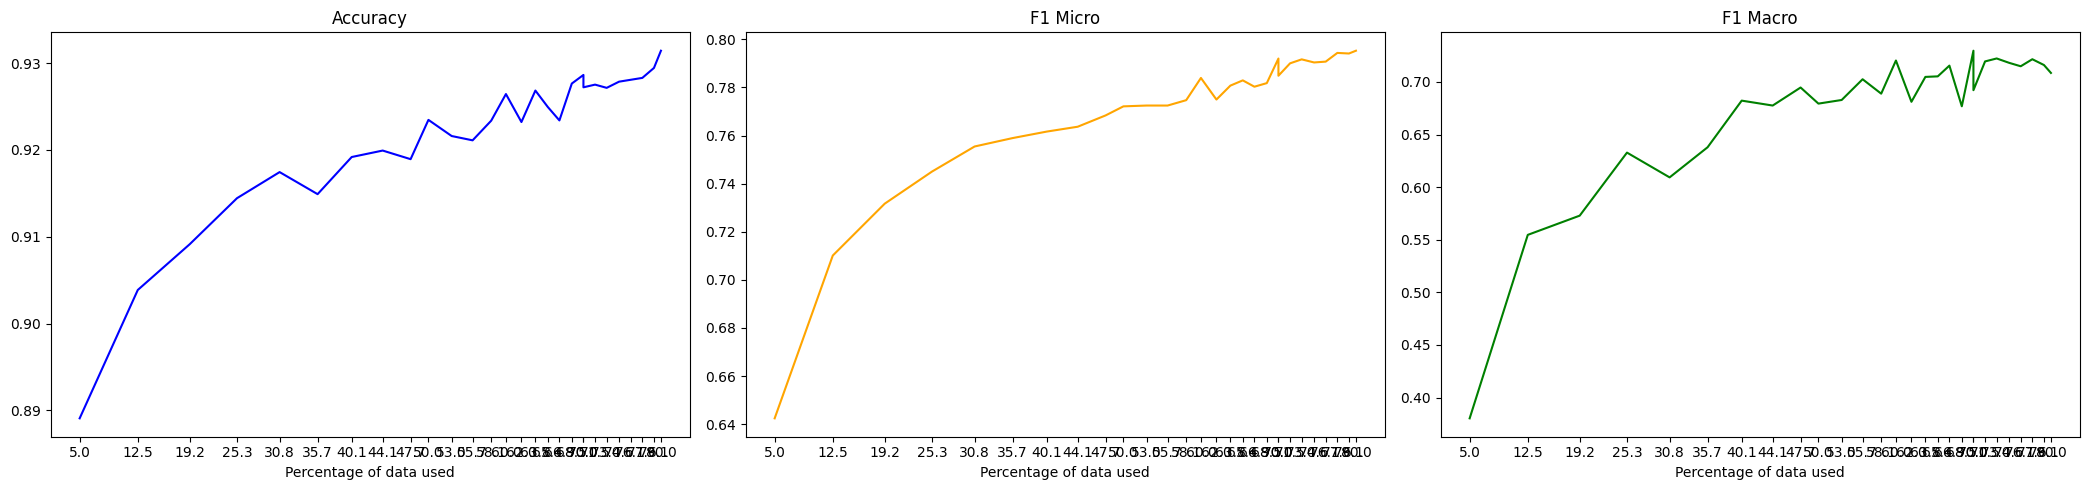

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8279, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.8342, F1 Micro: 0.1125, F1 Macro: 0.0406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.372, Accuracy: 0.844, F1 Micro: 0.2472, F1 Macro: 0.0837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.8621, F1 Micro: 0.468, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3382, Accuracy: 0.8729, F1 Micro: 0.5892, F1 Macro: 0.2711
Epoch 6/10, Train Loss: 0.2935, Accuracy: 0.8774, F1 Micro: 0.5687, F1 Macro: 0.2658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2645, Accuracy: 0.8822, F1 Micro: 0.6084, F1 Macro: 0.293
Epoch 8/10, Train Loss: 0.2436, Accuracy: 0.8842, F1 Micro: 0.6042, F1 Macro: 0.3032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2213, Accuracy: 0.8868, F1 Micro: 0.6313, F1 Macro: 0.3455
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8407, F1 Micro: 0.1891, F1 Macro: 0.0689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3687, Accuracy: 0.8752, F1 Micro: 0.5114, F1 Macro: 0.2353
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3026, Accuracy: 0.8854, F1 Micro: 0.5997, F1 Macro: 0.293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2614, Accuracy: 0.8929, F1 Micro: 0.6544, F1 Macro: 0.3753
Epoch 5/10, Train Loss: 0.2141, Accuracy: 0.8951, F1 Micro: 0.6457, F1 Macro: 0.4197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1961, Accuracy: 0.8978, F1 Micro: 0.6944, F1 Macro: 0.5104
Epoch 7/10, Train Loss: 0.1752, Accuracy: 0.9011, F1 Micro: 0.6899, F1 Macro: 0.5026
Epoch 8/10, Train Loss: 0.141, Accuracy: 0.902, F1 Micro: 0.6903, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1225, Accuracy: 0.9014, F1 Micro: 0.7015, F1 Macro: 0.5404
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4349, Accuracy: 0.8549, F1 Micro: 0.4046, F1 Macro: 0.126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3247, Accuracy: 0.8849, F1 Micro: 0.642, F1 Macro: 0.3301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2598, Accuracy: 0.8982, F1 Micro: 0.6738, F1 Macro: 0.4119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.9026, F1 Micro: 0.6898, F1 Macro: 0.4664
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.9045, F1 Micro: 0.6743, F1 Macro: 0.4703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9062, F1 Micro: 0.6927, F1 Macro: 0.5153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.9072, F1 Micro: 0.717, F1 Macro: 0.538
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9088, F1 Micro: 0.7107, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0954, Accuracy: 0.9089, F1 Micro: 0.7252, F1 Macro: 0.5794
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4082, Accuracy: 0.8673, F1 Micro: 0.4326, F1 Macro: 0.1874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.8949, F1 Micro: 0.6309, F1 Macro: 0.3724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9022, F1 Micro: 0.6835, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.9074, F1 Micro: 0.7166, F1 Macro: 0.53
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9091, F1 Micro: 0.7013, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9103, F1 Micro: 0.7292, F1 Macro: 0.5716
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9108, F1 Micro: 0.725, F1 Macro: 0.5867
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9072, F1 Micro: 0.7133, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9092, F1 Micro: 0.7303, F1 Macro: 0.5893
Epoch 10/10, Train Loss: 0.0664, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8745, F1 Micro: 0.4985, F1 Macro: 0.2279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9003, F1 Micro: 0.6791, F1 Macro: 0.4497
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.8949, F1 Micro: 0.7158, F1 Macro: 0.5283
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9073, F1 Micro: 0.6924, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9108, F1 Micro: 0.7262, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9118, F1 Micro: 0.7299, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9108, F1 Micro: 0.7434, F1 Macro: 0.6237
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9101, F1 Micro: 0.7383, F1 Macro: 0.6022
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9125, F1 Micro: 0.7372, F1 Macro: 0.6348
Epoch 10/10, Train Loss: 0.0628, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8842, F1 Micro: 0.6044, F1 Macro: 0.3063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.8984, F1 Micro: 0.6414, F1 Macro: 0.4402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9106, F1 Micro: 0.7048, F1 Macro: 0.5121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.914, F1 Micro: 0.7307, F1 Macro: 0.5626
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9142, F1 Micro: 0.7271, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9126, F1 Micro: 0.7375, F1 Macro: 0.6106
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9179, F1 Micro: 0.7537, F1 Macro: 0.6592
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9146, F1 Micro: 0.7473, F1 Macro: 0.617
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.918, F1 Micro: 0.7464, F1 Macro: 0.6439
Epoch 10/10, Train Loss: 0.061, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.8851, F1 Micro: 0.5775, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.9046, F1 Micro: 0.7154, F1 Macro: 0.4977
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9114, F1 Micro: 0.7082, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9116, F1 Micro: 0.7454, F1 Macro: 0.5839
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9133, F1 Micro: 0.7421, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9174, F1 Micro: 0.7488, F1 Macro: 0.6029
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9162, F1 Micro: 0.7468, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9144, F1 Micro: 0.7507, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9167, F1 Micro: 0.7529, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8899, F1 Micro: 0.634, F1 Macro: 0.3219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9087, F1 Micro: 0.7152, F1 Macro: 0.5191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9133, F1 Micro: 0.7429, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9165, F1 Micro: 0.7593, F1 Macro: 0.6201
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9189, F1 Micro: 0.7476, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9199, F1 Micro: 0.7647, F1 Macro: 0.6672
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9183, F1 Micro: 0.7459, F1 Macro: 0.6749
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.912, F1 Micro: 0.7549, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9181, F1 Micro: 0.7652, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3641, Accuracy: 0.8879, F1 Micro: 0.5946, F1 Macro: 0.3222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.236, Accuracy: 0.9068, F1 Micro: 0.7278, F1 Macro: 0.5062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.9161, F1 Micro: 0.7456, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.914, F1 Micro: 0.7518, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9167, F1 Micro: 0.756, F1 Macro: 0.6351
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9163, F1 Micro: 0.7517, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.92, F1 Micro: 0.7624, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9185, F1 Micro: 0.7632, F1 Macro: 0.6904
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9181, F1 Micro: 0.7557, F1 Macro: 0.6827
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3585, Accuracy: 0.8973, F1 Micro: 0.6688, F1 Macro: 0.376
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9103, F1 Micro: 0.7212, F1 Macro: 0.524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9129, F1 Micro: 0.7432, F1 Macro: 0.5815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9205, F1 Micro: 0.7525, F1 Macro: 0.6144
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.913, F1 Micro: 0.7528, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9182, F1 Micro: 0.7622, F1 Macro: 0.67
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9178, F1 Micro: 0.7616, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9176, F1 Micro: 0.7635, F1 Macro: 0.6835
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9169, F1 Micro: 0.7591, F1 Macro: 0.6894
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.8949, F1 Micro: 0.6469, F1 Macro: 0.4084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.91, F1 Micro: 0.7254, F1 Macro: 0.5161
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.918, F1 Micro: 0.7545, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9199, F1 Micro: 0.7606, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9192, F1 Micro: 0.7628, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9217, F1 Micro: 0.7674, F1 Macro: 0.6933
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9213, F1 Micro: 0.7664, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.921, F1 Micro: 0.7701, F1 Macro: 0.6992
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9235, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3551, Accuracy: 0.8965, F1 Micro: 0.6866, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9139, F1 Micro: 0.7324, F1 Macro: 0.5372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9175, F1 Micro: 0.7615, F1 Macro: 0.5984
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9214, F1 Micro: 0.7611, F1 Macro: 0.6399
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9204, F1 Micro: 0.7691, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9221, F1 Micro: 0.7702, F1 Macro: 0.674
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9151, F1 Micro: 0.7648, F1 Macro: 0.691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9237, F1 Micro: 0.7745, F1 Macro: 0.6954
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9226, F1 Micro: 0.766, F1 Macro: 0.6974
Epoch 10/10, Train Loss: 0.0436, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3462, Accuracy: 0.9, F1 Micro: 0.674, F1 Macro: 0.4446
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9109, F1 Micro: 0.7272, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.921, F1 Micro: 0.7625, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9231, F1 Micro: 0.7713, F1 Macro: 0.6623
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9214, F1 Micro: 0.765, F1 Macro: 0.6496
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9205, F1 Micro: 0.7706, F1 Macro: 0.6754
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9196, F1 Micro: 0.7667, F1 Macro: 0.6858
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9232, F1 Micro: 0.7699, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9256, F1 Micro: 0.7784, F1 Macro: 0.7114
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9224, F1 Micro: 0.7695, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8991, F1 Micro: 0.6965, F1 Macro: 0.4309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2287, Accuracy: 0.9122, F1 Micro: 0.7424, F1 Macro: 0.5562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9186, F1 Micro: 0.7552, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9226, F1 Micro: 0.7565, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9182, F1 Micro: 0.7684, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9211, F1 Micro: 0.771, F1 Macro: 0.6677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9217, F1 Micro: 0.7724, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.924, F1 Micro: 0.7759, F1 Macro: 0.6926
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.924, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3388, Accuracy: 0.9029, F1 Micro: 0.6941, F1 Macro: 0.4917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9148, F1 Micro: 0.7241, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9181, F1 Micro: 0.7541, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9233, F1 Micro: 0.7739, F1 Macro: 0.6689
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9173, F1 Micro: 0.7683, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9244, F1 Micro: 0.7748, F1 Macro: 0.6925
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9246, F1 Micro: 0.7731, F1 Macro: 0.6999
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9259, F1 Micro: 0.782, F1 Macro: 0.7111
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9219, F1 Micro: 0.778, F1 Macro: 0.712
Epoch 10/10, Train Loss: 0.0448, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3393, Accuracy: 0.9028, F1 Micro: 0.6999, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2299, Accuracy: 0.9152, F1 Micro: 0.7452, F1 Macro: 0.5662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9233, F1 Micro: 0.7686, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.924, F1 Micro: 0.7731, F1 Macro: 0.6624
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9208, F1 Micro: 0.7708, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9239, F1 Micro: 0.7764, F1 Macro: 0.6587
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9226, F1 Micro: 0.7731, F1 Macro: 0.7057
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9214, F1 Micro: 0.7757, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.924, F1 Micro: 0.777, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.34, Accuracy: 0.9046, F1 Micro: 0.6895, F1 Macro: 0.4506
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.917, F1 Micro: 0.7405, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9184, F1 Micro: 0.7565, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9221, F1 Micro: 0.765, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9244, F1 Micro: 0.7702, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9261, F1 Micro: 0.7765, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9221, F1 Micro: 0.7781, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9245, F1 Micro: 0.7753, F1 Macro: 0.7033
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9228, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3373, Accuracy: 0.9021, F1 Micro: 0.6711, F1 Macro: 0.442
Epoch 2/10, Train Loss: 0.2233, Accuracy: 0.9072, F1 Micro: 0.671, F1 Macro: 0.4963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.921, F1 Micro: 0.7723, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9243, F1 Micro: 0.7782, F1 Macro: 0.6771
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9229, F1 Micro: 0.7703, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9263, F1 Micro: 0.7786, F1 Macro: 0.7013
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.923, F1 Micro: 0.7738, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9264, F1 Micro: 0.7811, F1 Macro: 0.7106
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9219, F1 Micro: 0.7752, F1 Macro: 0.7124
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.9247, F1 Micro: 0.7752, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3382, Accuracy: 0.9049, F1 Micro: 0.6944, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.9185, F1 Micro: 0.7571, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9243, F1 Micro: 0.7628, F1 Macro: 0.6214
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9244, F1 Micro: 0.7772, F1 Macro: 0.6556
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9258, F1 Micro: 0.769, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9255, F1 Micro: 0.7839, F1 Macro: 0.7048
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9242, F1 Micro: 0.7798, F1 Macro: 0.7046
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9233, F1 Micro: 0.7791, F1 Macro: 0.7069
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9271, F1 Micro: 0.7868, F1 Macro: 0.7238
Epoch 10/10, Train Loss: 0.0405, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3371, Accuracy: 0.9055, F1 Micro: 0.6948, F1 Macro: 0.4439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9184, F1 Micro: 0.7544, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9218, F1 Micro: 0.7632, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9256, F1 Micro: 0.7769, F1 Macro: 0.6647
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9254, F1 Micro: 0.767, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9287, F1 Micro: 0.7855, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9284, F1 Micro: 0.7882, F1 Macro: 0.7164
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9269, F1 Micro: 0.787, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9239, F1 Micro: 0.7789, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3337, Accuracy: 0.8997, F1 Micro: 0.6565, F1 Macro: 0.3765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.9187, F1 Micro: 0.758, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9191, F1 Micro: 0.772, F1 Macro: 0.633
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9243, F1 Micro: 0.7654, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9245, F1 Micro: 0.7757, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9267, F1 Micro: 0.7856, F1 Macro: 0.7051
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9215, F1 Micro: 0.7789, F1 Macro: 0.7088
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9246, F1 Micro: 0.7806, F1 Macro: 0.7191
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9269, F1 Micro: 0.7788, F1 Macro: 0.7088
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.9253, F1 Micro: 0.7831, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3339, Accuracy: 0.901, F1 Micro: 0.6641, F1 Macro: 0.4216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9127, F1 Micro: 0.7147, F1 Macro: 0.5164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9234, F1 Micro: 0.772, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.925, F1 Micro: 0.7771, F1 Macro: 0.6542
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9259, F1 Micro: 0.7726, F1 Macro: 0.6542
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9274, F1 Micro: 0.7863, F1 Macro: 0.7095
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9257, F1 Micro: 0.7798, F1 Macro: 0.7042
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9249, F1 Micro: 0.7784, F1 Macro: 0.7048
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9247, F1 Micro: 0.7806, F1 Macro: 0.7116
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9275, F1 Micro: 0.7853, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3373, Accuracy: 0.9035, F1 Micro: 0.6721, F1 Macro: 0.4138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2252, Accuracy: 0.9163, F1 Micro: 0.76, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1795, Accuracy: 0.9252, F1 Micro: 0.7664, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9282, F1 Micro: 0.7858, F1 Macro: 0.6582
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9288, F1 Micro: 0.7807, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9266, F1 Micro: 0.7867, F1 Macro: 0.7076
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9239, F1 Micro: 0.7757, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9273, F1 Micro: 0.7832, F1 Macro: 0.7079
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9252, F1 Micro: 0.7831, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.039, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3363, Accuracy: 0.904, F1 Micro: 0.6999, F1 Macro: 0.5077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9191, F1 Micro: 0.7578, F1 Macro: 0.5668
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.924, F1 Micro: 0.7557, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9224, F1 Micro: 0.7643, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9266, F1 Micro: 0.7743, F1 Macro: 0.6713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9245, F1 Micro: 0.7862, F1 Macro: 0.7136
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9272, F1 Micro: 0.7829, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9256, F1 Micro: 0.7789, F1 Macro: 0.7047
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9262, F1 Micro: 0.7838, F1 Macro: 0.7189
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.92, F1 Micro: 0.7785, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.335, Accuracy: 0.8914, F1 Micro: 0.712, F1 Macro: 0.5007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.916, F1 Micro: 0.7581, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9249, F1 Micro: 0.7792, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9244, F1 Micro: 0.782, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9277, F1 Micro: 0.7897, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9285, F1 Micro: 0.7924, F1 Macro: 0.709
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9265, F1 Micro: 0.7825, F1 Macro: 0.7099
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9279, F1 Micro: 0.7829, F1 Macro: 0.7065
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9253, F1 Micro: 0.7773, F1 Macro: 0.7094
Epoch 10/10, Train Loss: 0.0406, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3333, Accuracy: 0.9045, F1 Micro: 0.6949, F1 Macro: 0.4552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9191, F1 Micro: 0.76, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9254, F1 Micro: 0.7677, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9235, F1 Micro: 0.7862, F1 Macro: 0.6756
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9274, F1 Micro: 0.7801, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9266, F1 Micro: 0.7872, F1 Macro: 0.6969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9291, F1 Micro: 0.7883, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9301, F1 Micro: 0.7898, F1 Macro: 0.7245
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9236, F1 Micro: 0.7774, F1 Macro: 0.7147
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3328, Accuracy: 0.9043, F1 Micro: 0.7024, F1 Macro: 0.4653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2154, Accuracy: 0.9188, F1 Micro: 0.7446, F1 Macro: 0.5409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9261, F1 Micro: 0.7682, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.9286, F1 Micro: 0.7866, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9291, F1 Micro: 0.7876, F1 Macro: 0.6963
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9272, F1 Micro: 0.7791, F1 Macro: 0.7047
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9302, F1 Micro: 0.7917, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9288, F1 Micro: 0.7887, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9305, F1 Micro: 0.7903, F1 Macro: 0.7178
Epoch 10/10, Train Loss: 0.0409, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9019, F1 Micro: 0.6499, F1 Macro: 0.4144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9192, F1 Micro: 0.7467, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9254, F1 Micro: 0.7831, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1339, Accuracy: 0.9274, F1 Micro: 0.7861, F1 Macro: 0.6848
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9233, F1 Micro: 0.7847, F1 Macro: 0.7071
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9293, F1 Micro: 0.7914, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9264, F1 Micro: 0.7918, F1 Macro: 0.7137
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9254, F1 Micro: 0.7862, F1 Macro: 0.7238
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9236, F1 Micro: 0.779, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 

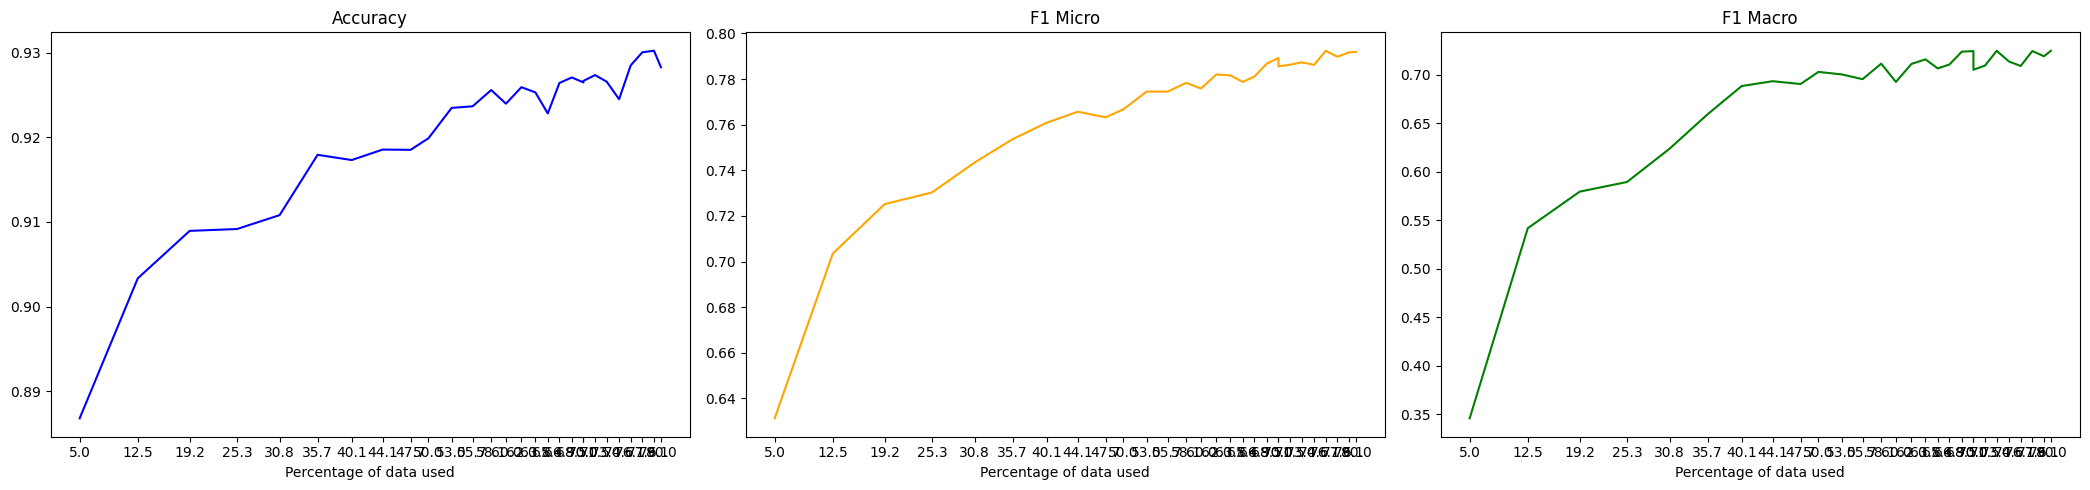

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.8348, F1 Micro: 0.1412, F1 Macro: 0.0514
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.833, F1 Micro: 0.088, F1 Macro: 0.0343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.85, F1 Micro: 0.3323, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3599, Accuracy: 0.8618, F1 Micro: 0.4297, F1 Macro: 0.1746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3369, Accuracy: 0.8752, F1 Micro: 0.5274, F1 Macro: 0.2436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2854, Accuracy: 0.8782, F1 Micro: 0.5421, F1 Macro: 0.254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2723, Accuracy: 0.8832, F1 Micro: 0.5806, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2324, Accuracy: 0.8863, F1 Micro: 0.611, F1 Macro: 0.3353
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2048, Accuracy: 0.8859, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4677, Accuracy: 0.8408, F1 Micro: 0.1791, F1 Macro: 0.0665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3589, Accuracy: 0.8725, F1 Micro: 0.5749, F1 Macro: 0.261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3008, Accuracy: 0.8842, F1 Micro: 0.6383, F1 Macro: 0.3289
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2628, Accuracy: 0.8893, F1 Micro: 0.646, F1 Macro: 0.4394
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2232, Accuracy: 0.8941, F1 Micro: 0.6736, F1 Macro: 0.4445
Epoch 6/10, Train Loss: 0.2006, Accuracy: 0.8969, F1 Micro: 0.671, F1 Macro: 0.4408
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1655, Accuracy: 0.8967, F1 Micro: 0.6835, F1 Macro: 0.4797
Epoch 8/10, Train Loss: 0.1428, Accuracy: 0.8967, F1 Micro: 0.6697, F1 Macro: 0.4449
Epoch 9/10, Train Loss: 0.1329, Accuracy: 0.8983, F1 Micro: 0.6721, F1 Macro: 0.493
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.434, Accuracy: 0.8494, F1 Micro: 0.2779, F1 Macro: 0.0958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.324, Accuracy: 0.886, F1 Micro: 0.6209, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2631, Accuracy: 0.8961, F1 Micro: 0.6803, F1 Macro: 0.4724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2201, Accuracy: 0.9014, F1 Micro: 0.6949, F1 Macro: 0.4886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9042, F1 Micro: 0.7021, F1 Macro: 0.5053
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1565, Accuracy: 0.9058, F1 Micro: 0.705, F1 Macro: 0.5231
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.9027, F1 Micro: 0.691, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1111, Accuracy: 0.9086, F1 Micro: 0.7198, F1 Macro: 0.5581
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0948, Accuracy: 0.9086, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4152, Accuracy: 0.8749, F1 Micro: 0.5568, F1 Macro: 0.2543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2857, Accuracy: 0.8931, F1 Micro: 0.617, F1 Macro: 0.3418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9011, F1 Micro: 0.7067, F1 Macro: 0.4989
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.9062, F1 Micro: 0.7042, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9111, F1 Micro: 0.7286, F1 Macro: 0.5521
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9089, F1 Micro: 0.7268, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9102, F1 Micro: 0.7338, F1 Macro: 0.5661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9129, F1 Micro: 0.7343, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9132, F1 Micro: 0.7382, F1 Macro: 0.6023
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8806, F1 Micro: 0.5791, F1 Macro: 0.2694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.8987, F1 Micro: 0.6526, F1 Macro: 0.4184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2182, Accuracy: 0.907, F1 Micro: 0.6985, F1 Macro: 0.4933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9117, F1 Micro: 0.723, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9129, F1 Micro: 0.7315, F1 Macro: 0.545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9126, F1 Micro: 0.7358, F1 Macro: 0.5822
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9137, F1 Micro: 0.7326, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9105, F1 Micro: 0.7406, F1 Macro: 0.5972
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9141, F1 Micro: 0.7348, F1 Macro: 0.6098
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8853, F1 Micro: 0.6436, F1 Macro: 0.3563
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.9046, F1 Micro: 0.7015, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9104, F1 Micro: 0.7327, F1 Macro: 0.528
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9123, F1 Micro: 0.7081, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9166, F1 Micro: 0.7463, F1 Macro: 0.5958
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9142, F1 Micro: 0.7438, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9156, F1 Micro: 0.7557, F1 Macro: 0.6321
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9162, F1 Micro: 0.7508, F1 Macro: 0.626
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9175, F1 Micro: 0.7517, F1 Macro: 0.6327
Epoch 10/10, Train Loss: 0.0606, Accuracy: 0.9161, F1 Micro: 0.7488, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8862, F1 Micro: 0.6495, F1 Macro: 0.3352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9087, F1 Micro: 0.7116, F1 Macro: 0.5144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9112, F1 Micro: 0.743, F1 Macro: 0.5691
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9152, F1 Micro: 0.726, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9168, F1 Micro: 0.7484, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9183, F1 Micro: 0.7527, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9159, F1 Micro: 0.7544, F1 Macro: 0.6371
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9169, F1 Micro: 0.7512, F1 Macro: 0.6238
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9177, F1 Micro: 0.7539, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3626, Accuracy: 0.8895, F1 Micro: 0.6682, F1 Macro: 0.3544
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9073, F1 Micro: 0.7234, F1 Macro: 0.5309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9165, F1 Micro: 0.7489, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9156, F1 Micro: 0.7579, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9195, F1 Micro: 0.7597, F1 Macro: 0.6159
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9204, F1 Micro: 0.7521, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.921, F1 Micro: 0.7708, F1 Macro: 0.6538
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9213, F1 Micro: 0.7567, F1 Macro: 0.6646
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9196, F1 Micro: 0.7645, F1 Macro: 0.6851
Epoch 10/10, Train Loss: 0.0505, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3553, Accuracy: 0.8957, F1 Micro: 0.6592, F1 Macro: 0.4277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.9107, F1 Micro: 0.7108, F1 Macro: 0.5279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9158, F1 Micro: 0.7275, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9203, F1 Micro: 0.7611, F1 Macro: 0.5976
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9158, F1 Micro: 0.7586, F1 Macro: 0.6209
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9179, F1 Micro: 0.7606, F1 Macro: 0.6321
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9212, F1 Micro: 0.7562, F1 Macro: 0.6615
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9148, F1 Micro: 0.7609, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9202, F1 Micro: 0.769, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0473, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.8957, F1 Micro: 0.6418, F1 Macro: 0.3868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.9121, F1 Micro: 0.722, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.919, F1 Micro: 0.7631, F1 Macro: 0.6024
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9218, F1 Micro: 0.7597, F1 Macro: 0.6161
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9204, F1 Micro: 0.757, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9199, F1 Micro: 0.766, F1 Macro: 0.6492
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9196, F1 Micro: 0.7621, F1 Macro: 0.661
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.918, F1 Micro: 0.7583, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9217, F1 Micro: 0.7663, F1 Macro: 0.6865
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.9213, F1 Micro: 0.7613, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.898, F1 Micro: 0.6546, F1 Macro: 0.383
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2305, Accuracy: 0.9068, F1 Micro: 0.7263, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9155, F1 Micro: 0.7575, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9164, F1 Micro: 0.7627, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9197, F1 Micro: 0.7685, F1 Macro: 0.6494
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9206, F1 Micro: 0.7624, F1 Macro: 0.6299
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9223, F1 Micro: 0.7684, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9217, F1 Micro: 0.7737, F1 Macro: 0.6929
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.924, F1 Micro: 0.7701, F1 Macro: 0.7004
Epoch 10/10, Train Loss: 0.0456, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3487, Accuracy: 0.8988, F1 Micro: 0.6748, F1 Macro: 0.4488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9129, F1 Micro: 0.7395, F1 Macro: 0.5709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9198, F1 Micro: 0.75, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9214, F1 Micro: 0.7629, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9231, F1 Micro: 0.763, F1 Macro: 0.6284
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9213, F1 Micro: 0.7658, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9203, F1 Micro: 0.7691, F1 Macro: 0.6888
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9205, F1 Micro: 0.7677, F1 Macro: 0.697
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9182, F1 Micro: 0.7616, F1 Macro: 0.6908
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.345, Accuracy: 0.9005, F1 Micro: 0.684, F1 Macro: 0.429
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2303, Accuracy: 0.9126, F1 Micro: 0.7269, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.9184, F1 Micro: 0.7374, F1 Macro: 0.5782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9235, F1 Micro: 0.7739, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9251, F1 Micro: 0.7769, F1 Macro: 0.6765
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9192, F1 Micro: 0.7707, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9262, F1 Micro: 0.7786, F1 Macro: 0.6912
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9202, F1 Micro: 0.7727, F1 Macro: 0.7006
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9255, F1 Micro: 0.78, F1 Macro: 0.7122
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3419, Accuracy: 0.8984, F1 Micro: 0.6964, F1 Macro: 0.4639
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9119, F1 Micro: 0.7473, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9217, F1 Micro: 0.7599, F1 Macro: 0.6209
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9199, F1 Micro: 0.7486, F1 Macro: 0.6205
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9212, F1 Micro: 0.7496, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.925, F1 Micro: 0.7809, F1 Macro: 0.6841
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9216, F1 Micro: 0.7775, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9255, F1 Micro: 0.7769, F1 Macro: 0.7068
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9236, F1 Micro: 0.7746, F1 Macro: 0.7133
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9236, F1 Micro: 0.7711, F1 Macro: 0.7015

 Iteration 7901: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3449, Accuracy: 0.8925, F1 Micro: 0.6194, F1 Macro: 0.3183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2236, Accuracy: 0.9133, F1 Micro: 0.7537, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9218, F1 Micro: 0.7565, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9248, F1 Micro: 0.7648, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9249, F1 Micro: 0.7738, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9231, F1 Micro: 0.7771, F1 Macro: 0.6975
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9235, F1 Micro: 0.7754, F1 Macro: 0.6946
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9217, F1 Micro: 0.773, F1 Macro: 0.7023
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9256, F1 Micro: 0.7758, F1 Macro: 0.6988
Epoch 10/10, Train Loss: 0.0454, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.344, Accuracy: 0.9014, F1 Micro: 0.6646, F1 Macro: 0.4328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2269, Accuracy: 0.9148, F1 Micro: 0.7443, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9167, F1 Micro: 0.7522, F1 Macro: 0.5969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9263, F1 Micro: 0.7746, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.922, F1 Micro: 0.7755, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9265, F1 Micro: 0.7785, F1 Macro: 0.6937
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.927, F1 Micro: 0.7806, F1 Macro: 0.7049
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9254, F1 Micro: 0.7809, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3424, Accuracy: 0.8995, F1 Micro: 0.6672, F1 Macro: 0.422
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.9141, F1 Micro: 0.741, F1 Macro: 0.5349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9209, F1 Micro: 0.7525, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.926, F1 Micro: 0.775, F1 Macro: 0.6672
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9243, F1 Micro: 0.7703, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9258, F1 Micro: 0.7763, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.928, F1 Micro: 0.7855, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.929, F1 Micro: 0.7896, F1 Macro: 0.7128
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9274, F1 Micro: 0.7809, F1 Macro: 0.7091
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3348, Accuracy: 0.9029, F1 Micro: 0.6776, F1 Macro: 0.4826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.226, Accuracy: 0.9132, F1 Micro: 0.7445, F1 Macro: 0.5615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9243, F1 Micro: 0.7726, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9222, F1 Micro: 0.7728, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9266, F1 Micro: 0.7776, F1 Macro: 0.682
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9254, F1 Micro: 0.7733, F1 Macro: 0.6804
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9273, F1 Micro: 0.7807, F1 Macro: 0.7098
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9226, F1 Micro: 0.7763, F1 Macro: 0.7065
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9289, F1 Micro: 0.7888, F1 Macro: 0.715
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3428, Accuracy: 0.9037, F1 Micro: 0.6857, F1 Macro: 0.4615
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.9186, F1 Micro: 0.7464, F1 Macro: 0.5578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9251, F1 Micro: 0.7734, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9246, F1 Micro: 0.7793, F1 Macro: 0.649
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9205, F1 Micro: 0.777, F1 Macro: 0.6771
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9211, F1 Micro: 0.7792, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.926, F1 Micro: 0.7798, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9243, F1 Micro: 0.7843, F1 Macro: 0.7169
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9253, F1 Micro: 0.7697, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3322, Accuracy: 0.903, F1 Micro: 0.7085, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.221, Accuracy: 0.9174, F1 Micro: 0.7444, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.9246, F1 Micro: 0.7662, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9239, F1 Micro: 0.7823, F1 Macro: 0.6454
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9259, F1 Micro: 0.7778, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9254, F1 Micro: 0.7836, F1 Macro: 0.7068
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9283, F1 Micro: 0.7819, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9252, F1 Micro: 0.7838, F1 Macro: 0.71
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9286, F1 Micro: 0.7878, F1 Macro: 0.7223
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3318, Accuracy: 0.904, F1 Micro: 0.6931, F1 Macro: 0.4346
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.228, Accuracy: 0.9173, F1 Micro: 0.7345, F1 Macro: 0.5631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9203, F1 Micro: 0.7641, F1 Macro: 0.6346
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9226, F1 Micro: 0.7518, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.927, F1 Micro: 0.7816, F1 Macro: 0.6726
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9193, F1 Micro: 0.7773, F1 Macro: 0.6852
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9269, F1 Micro: 0.7777, F1 Macro: 0.6983
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9227, F1 Micro: 0.7733, F1 Macro: 0.7034
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9276, F1 Micro: 0.7811, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9255, F1 Micro: 0.788, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3323, Accuracy: 0.9047, F1 Micro: 0.7065, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.9182, F1 Micro: 0.7445, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9213, F1 Micro: 0.7722, F1 Macro: 0.63
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9254, F1 Micro: 0.7674, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.927, F1 Micro: 0.7896, F1 Macro: 0.7083
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9263, F1 Micro: 0.7839, F1 Macro: 0.6855
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9258, F1 Micro: 0.7827, F1 Macro: 0.7127
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9251, F1 Micro: 0.7844, F1 Macro: 0.7183
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9252, F1 Micro: 0.7856, F1 Macro: 0.7195
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9242, F1 Micro: 0.7739, F1 Macro: 0.7105

 Iteration 9418: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.335, Accuracy: 0.904, F1 Micro: 0.6821, F1 Macro: 0.4826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2217, Accuracy: 0.9189, F1 Micro: 0.7635, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9266, F1 Micro: 0.7834, F1 Macro: 0.6382
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9274, F1 Micro: 0.7768, F1 Macro: 0.6659
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9252, F1 Micro: 0.7831, F1 Macro: 0.6824
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.926, F1 Micro: 0.7867, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9279, F1 Micro: 0.7885, F1 Macro: 0.706
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9266, F1 Micro: 0.7864, F1 Macro: 0.7144
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9239, F1 Micro: 0.7821, F1 Macro: 0.7165
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9231, F1 Micro: 0.7846, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.9041, F1 Micro: 0.7157, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2216, Accuracy: 0.9213, F1 Micro: 0.7515, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.9234, F1 Micro: 0.7773, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9246, F1 Micro: 0.7809, F1 Macro: 0.6837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9293, F1 Micro: 0.7871, F1 Macro: 0.6964
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9222, F1 Micro: 0.7837, F1 Macro: 0.6852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9289, F1 Micro: 0.7914, F1 Macro: 0.7165
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9269, F1 Micro: 0.7798, F1 Macro: 0.7105
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9253, F1 Micro: 0.7848, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3311, Accuracy: 0.9034, F1 Micro: 0.6721, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2232, Accuracy: 0.9186, F1 Micro: 0.7637, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9169, F1 Micro: 0.7692, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9257, F1 Micro: 0.7875, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9279, F1 Micro: 0.7886, F1 Macro: 0.6875
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9274, F1 Micro: 0.7768, F1 Macro: 0.6841
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9265, F1 Micro: 0.7854, F1 Macro: 0.7122
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9264, F1 Micro: 0.7824, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9251, F1 Micro: 0.7866, F1 Macro: 0.721
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.927, F1 Micro: 0.7871, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3295, Accuracy: 0.9038, F1 Micro: 0.6761, F1 Macro: 0.4473
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9175, F1 Micro: 0.7525, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9262, F1 Micro: 0.7795, F1 Macro: 0.6284
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9258, F1 Micro: 0.7886, F1 Macro: 0.6609
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9281, F1 Micro: 0.7877, F1 Macro: 0.6969
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9225, F1 Micro: 0.7829, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9267, F1 Micro: 0.7896, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9271, F1 Micro: 0.7938, F1 Macro: 0.7315
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9247, F1 Micro: 0.7871, F1 Macro: 0.7238
Epoch 10/10, Train Loss: 0.0431, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3279, Accuracy: 0.9057, F1 Micro: 0.6884, F1 Macro: 0.4428
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9187, F1 Micro: 0.7616, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9223, F1 Micro: 0.7768, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9271, F1 Micro: 0.7844, F1 Macro: 0.6676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9262, F1 Micro: 0.7889, F1 Macro: 0.7114
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9237, F1 Micro: 0.7812, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9281, F1 Micro: 0.7901, F1 Macro: 0.712
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9299, F1 Micro: 0.7882, F1 Macro: 0.7069
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.924, F1 Micro: 0.784, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.9062, F1 Micro: 0.6877, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9162, F1 Micro: 0.75, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9233, F1 Micro: 0.7726, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9222, F1 Micro: 0.7771, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9267, F1 Micro: 0.7895, F1 Macro: 0.6901
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9281, F1 Micro: 0.7793, F1 Macro: 0.6969
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9239, F1 Micro: 0.7848, F1 Macro: 0.714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9268, F1 Micro: 0.7901, F1 Macro: 0.7164
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.921, F1 Micro: 0.7801, F1 Macro: 0.7136
Epoch 10/10, Train Loss: 0.042, Accuracy: 

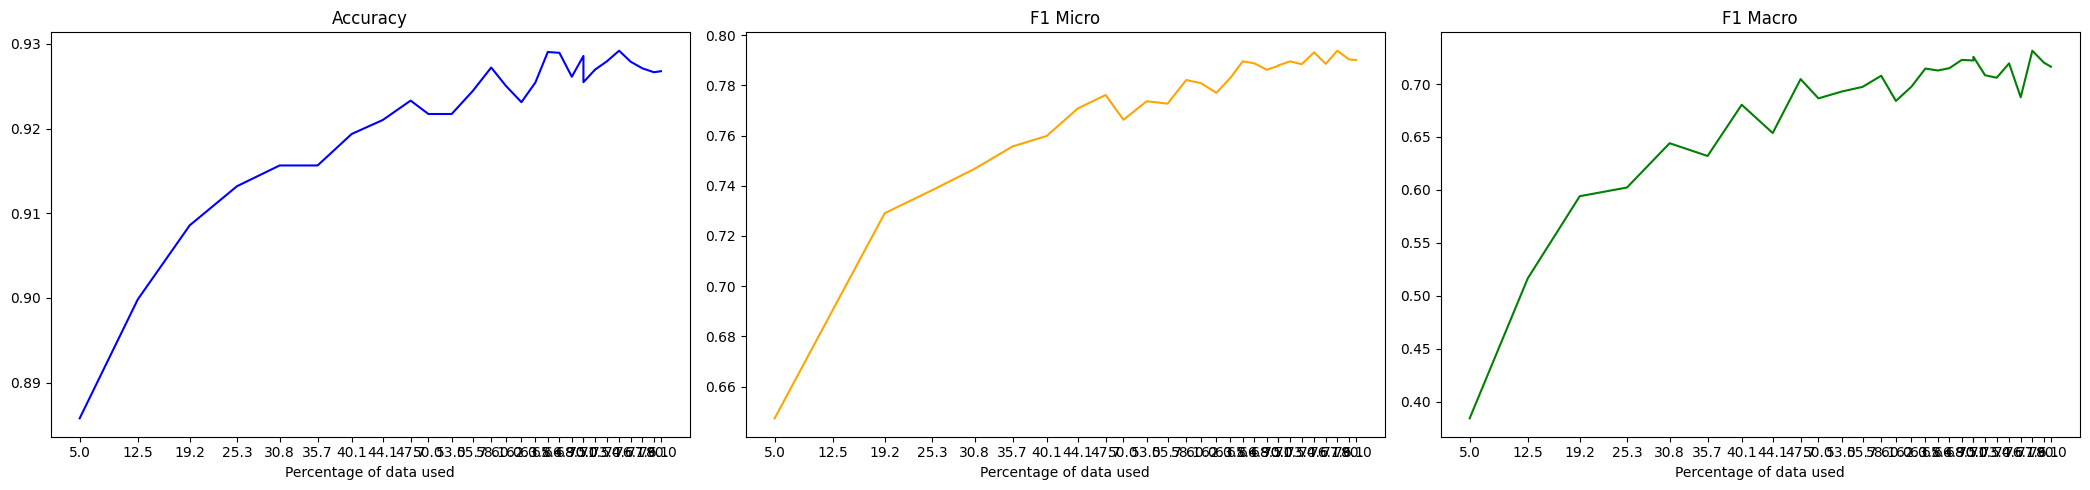

In [ ]:
active_learning(seeds[4], 4)